In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
employee_data: pd.DataFrame = pd.DataFrame()

In [3]:
def load_employee_data():
    global full_employee_data

    general_data = pd.read_csv('datasets/general_data.csv')
    employee_survey_data = pd.read_csv('datasets/employee_survey_data.csv')
    manager_survey_data = pd.read_csv('datasets/manager_survey_data.csv')

    full_employee_data = general_data.merge(employee_survey_data, on='EmployeeID')
    full_employee_data = full_employee_data.merge(manager_survey_data, on='EmployeeID')


load_employee_data()

In [4]:
def create_working_time_columns():
    """
        Process in_time.csv and out_time.csv data to create working time columns in the general_data dataframe
    """
    global full_employee_data
    in_time: pd.DataFrame = pd.read_csv('datasets/in_time.csv', on_bad_lines='warn').astype('datetime64[s]')
    out_time = pd.read_csv('datasets/out_time.csv', on_bad_lines='warn').astype('datetime64[s]')

    average: pd.DataFrame = (out_time - in_time)

    # Convert to hours
    average = average.loc[:, :] / np.timedelta64(1, 'h')

    working_time_df = pd.DataFrame()

    # Create a column EmployeeID
    working_time_df['EmployeeID'] = in_time.iloc[:, 0]
    working_time_df['EmployeeID'] = working_time_df['EmployeeID'].astype('int64')

    # Create a column min and max
    working_time_df['AverageArrivalTime'] = in_time.iloc[:, 1:].mean(axis=1)
    working_time_df['AverageDepartureTime'] = out_time.iloc[:, 1:].max(axis=1)

    # Create a column average
    working_time_df['AverageWorkingTime'] = average.mean(axis=1).round(2)

    # Merge the working time data with the general data
    full_employee_data = full_employee_data.merge(working_time_df, on='EmployeeID')


create_working_time_columns()

In [5]:
full_employee_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AverageArrivalTime,AverageDepartureTime,AverageWorkingTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,0,0,3.0,4.0,2.0,3,3,2015-07-01 20:02:09,2015-12-31 17:17:33,7.34
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,1,4,3.0,2.0,4.0,2,4,2015-07-02 21:34:52,2015-12-31 17:40:58,7.69
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,0,3,2.0,2.0,1.0,3,3,2015-07-02 07:38:41,2015-12-31 17:15:50,6.98
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,7,5,4.0,4.0,3.0,2,3,2015-07-02 14:53:02,2015-12-31 17:09:14,7.16
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,0,4,4.0,1.0,3.0,3,3,2015-07-03 11:04:33,2015-12-31 17:42:14,7.97


In [6]:
full_employee_data.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AverageArrivalTime,AverageDepartureTime,AverageWorkingTime
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,...,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000,4410,4410,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,8.0,...,2.187755,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741,2015-07-02 13:33:37,2015-12-31 16:26:48,7.668308
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2015-06-25 23:23:58,2015-12-28 16:23:16,5.920000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,...,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2015-07-01 14:22:27,2015-12-31 16:31:33,6.642500
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,...,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2015-07-02 13:04:22,2015-12-31 17:19:53,7.380000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,...,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,2015-07-03 13:10:49,2015-12-31 18:18:57,8.330000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,...,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2015-07-08 15:12:23,2015-12-31 21:56:13,10.980000
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.0,...,3.221699,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742,NaN,NaN,1.334767


In [7]:
# EmployeeCount : All values are 1
# Over18 : All values are 'Y'
# StandardHours : All values are 8
full_employee_data = full_employee_data.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1)

In [8]:
#Encoding
cat_data = ['Attrition', 'Gender', 'Department', 'BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus']
for i in cat_data:
    vals = pd.get_dummies(full_employee_data[i], sparse=True)
    full_employee_data = pd.concat([full_employee_data, vals], axis=1)

In [9]:
full_employee_data = full_employee_data.drop(['Attrition', 'Gender', 'Department', 'BusinessTravel', 'EducationField', 'JobRole', 'MaritalStatus'], axis=1)

In [10]:

full_employee_data.to_csv('cleaned_data.csv', index=False)


In [11]:
#Imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
for i in full_employee_data.columns:
    full_employee_data[i] = imputer.fit_transform(full_employee_data[[i]])

print(full_employee_data.isnull().sum())

Age                          0
DistanceFromHome             0
Education                    0
EmployeeID                   0
JobLevel                     0
MonthlyIncome                0
NumCompaniesWorked           0
PercentSalaryHike            0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
YearsAtCompany               0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
EnvironmentSatisfaction      0
JobSatisfaction              0
WorkLifeBalance              0
JobInvolvement               0
PerformanceRating            0
AverageArrivalTime           0
AverageDepartureTime         0
AverageWorkingTime           0
No                           0
Yes                          0
Female                       0
Male                         0
Human Resources              0
Research & Development       0
Sales                        0
Non-Travel                   0
Travel_Frequently            0
Travel_Rarely                0
Human Re

In [12]:
#Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for i in full_employee_data.columns:
    full_employee_data[i] = scaler.fit_transform(full_employee_data[[i]])
full_employee_data

,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,Divorced,Married,Single
0,0.785714,0.178571,0.25,0.000000,0.00,0.637546,0.111111,0.000000,0.000000,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.309524,0.321429,0.00,0.000227,0.00,0.167457,0.000000,0.857143,0.333333,0.150,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.333333,0.571429,0.75,0.000454,0.75,0.964666,0.111111,0.285714,1.000000,0.125,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.476190,0.035714,1.00,0.000680,0.50,0.385045,0.333333,0.000000,1.000000,0.325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.333333,0.321429,0.00,0.000907,0.00,0.070195,0.444444,0.071429,0.666667,0.225,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0.571429,0.142857,0.75,0.999093,0.00,0.264350,0.333333,0.428571,0.333333,0.250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4406,0.261905,0.035714,0.75,0.999320,0.00,0.087941,0.222222,0.285714,0.000000,0.250,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4407,0.166667,0.857143,0.25,0.999546,0.25,0.141811,0.000000,0.642857,0.000000,0.125,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4408,0.571429,0.607143,0.25,0.999773,0.00,0.073144,0.000000,0.214286,0.333333,0.250,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


        Age  DistanceFromHome  Education  EmployeeID  JobLevel  MonthlyIncome  \
0  0.785714          0.178571       0.25    0.000000      0.00       0.637546   
1  0.309524          0.321429       0.00    0.000227      0.00       0.167457   
2  0.333333          0.571429       0.75    0.000454      0.75       0.964666   
3  0.476190          0.035714       1.00    0.000680      0.50       0.385045   
4  0.333333          0.321429       0.00    0.000907      0.00       0.070195   

   NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  TotalWorkingYears  \
0            0.111111           0.000000          0.000000              0.025   
1            0.000000           0.857143          0.333333              0.150   
2            0.111111           0.285714          1.000000              0.125   
3            0.333333           0.000000          1.000000              0.325   
4            0.444444           0.071429          0.666667              0.225   

   ...  Laboratory Technic

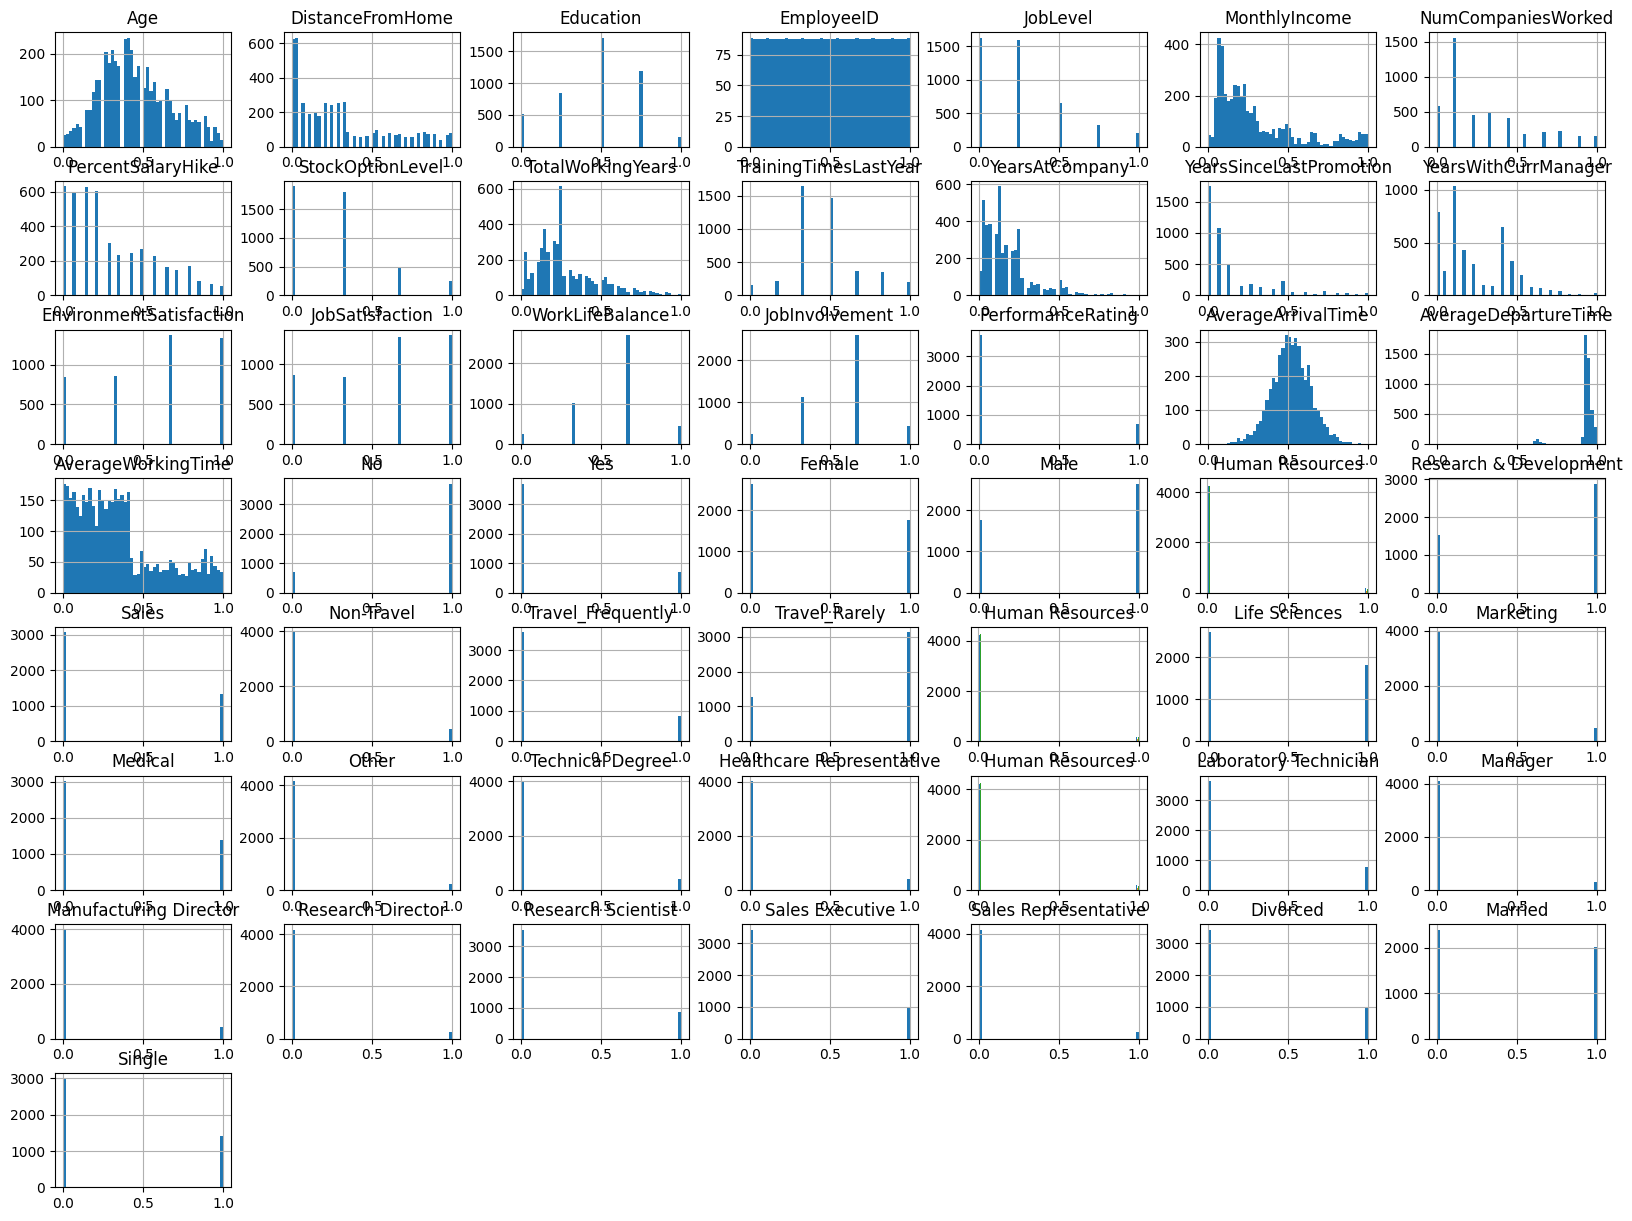

In [13]:
# Display the first 5 rows of the data
print(full_employee_data.head())

# Display the shape of the data
print(full_employee_data.shape)

# Display the columns of the data
print(full_employee_data.columns)

# Display the summary statistics of the data
print(full_employee_data.describe(include='all'))

# Display the missing values in the data
print(full_employee_data.isnull().sum())

# Display the unique values in the data
full_employee_data.hist(bins=50, figsize=(20, 15))
plt.show()